Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:

бустинг

логистическая регрессия

Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:

1 доллар на удержание

2 доллара - с каждого правильно классифицированного (True Positive)

*Провести подбор гиперпараметров лучшей модели по итогам 2-3

*Еще раз провести оценку экономической эффективности

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score


from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix



In [3]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:

бустинг

логистическая регрессия

Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Exited', axis=1), 
                                                    df['Exited'], random_state=0)

In [8]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.key]
    
    
class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler
    
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [9]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.        ,  1.        ,  0.        , ...,  0.67316003,
         2.53503394, -1.64080994],
       [ 1.        ,  0.        ,  0.        , ..., -1.20772417,
         0.80424154, -0.07927152],
       [ 0.        ,  0.        ,  1.        , ..., -0.35693706,
         0.80424154, -0.99684012],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  1.36657199,
         0.80424154,  1.4133552 ],
       [ 0.        ,  0.        ,  1.        , ..., -1.20772417,
         0.80424154,  0.84496184],
       [ 0.        ,  1.        ,  0.        , ...,  0.51741687,
        -0.92655087,  0.32500428]])

In [10]:
def training(classifier):
    from sklearn.metrics import roc_auc_score

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    # расчтаем метрики
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc_score = roc_auc_score(y_test, y_score)
    ix = np.argmax(fscore)
    cm = confusion_matrix(y_test, y_score>thresholds[ix])
 
    return [round(i, 3) for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score, cm[1,1], cm[0,1], cm[0,0], cm[1,0]]]

In [11]:
#!pip install xgboost

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [13]:
results = pd.DataFrame([
    training(classifier=Pipeline([('features', feats), ('classifier', LogisticRegression(random_state=42))])),
    training(classifier=Pipeline([('features', feats), ('classifier', RandomForestClassifier(random_state=42))])),
    training(classifier=Pipeline([('features', feats), ('classifier', GradientBoostingClassifier(random_state=42))])),
    training(classifier=Pipeline([('features', feats), ('classifier', xgb.XGBClassifier(random_state=42, 
                                                                                        use_label_encoder=False, 
                                                                                        eval_metric='logloss'))])) 
], columns=['Best Threshold', 'F', 'Precision', 'Recall', 'ROC AUC', 'TP', 'FP', 'TN', 'FN'])

results['models'] = ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 
                     'XGBClassifier']
results = results.set_index('models')

In [14]:
results

,Best Threshold,F,Precision,Recall,ROC AUC,TP,FP,TN,FN
models,,,,,,,,,
LogisticRegression,0.290,0.510,0.462,0.568,0.772,288,336,1655,221
RandomForestClassifier,0.380,0.641,0.654,0.629,0.864,314,158,1833,195
GradientBoostingClassifier,0.409,0.646,0.704,0.597,0.876,303,128,1863,206
XGBClassifier,0.373,0.626,0.619,0.633,0.861,321,198,1793,188


Наиболее подходщая метрика это Precision. Т.о. лучшая модель -  GradientBoostingClassifier. 

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:

1 доллар на удержание

2 доллара - с каждого правильно классифицированного (True Positive)

In [63]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier()),
])

In [64]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                   

In [17]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

In [25]:
import matplotlib.pyplot as plt
import itertools

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


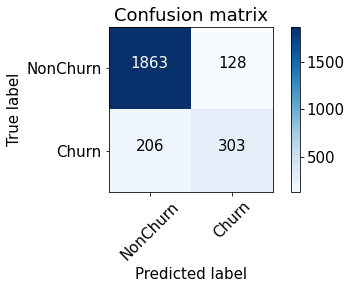

In [27]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [28]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

175

*Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [30]:
from sklearn.model_selection import GridSearchCV

params = {
    'classifier__n_estimators':[50, 100, 300, 500],
    'classifier__min_samples_leaf': [0.5, 1, 3, 5, 8], 
    'classifier__max_depth':[1, 3, 4, 7]
}

In [641]:
%%time
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Wall time: 16min 35s


{'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 3,
 'classifier__n_estimators': 300}

In [65]:
results = pd.DataFrame([
    training(classifier=Pipeline([('features', feats), ('classifier', LogisticRegression(random_state=42))])),
    training(classifier=Pipeline([('features', feats), ('classifier', RandomForestClassifier(random_state=42))])),
    training(classifier=Pipeline([('features', feats), ('classifier', xgb.XGBClassifier(random_state=42, 
                                                                                        use_label_encoder=False, 
                                                                                        eval_metric='logloss'))])),
    training(classifier=Pipeline([('features', feats), ('classifier', GradientBoostingClassifier(random_state=42))])),
    training(classifier=Pipeline([('features', feats), ('classifier', GradientBoostingClassifier(#random_state=24,
                                                                                                 max_depth=3, 
                                                                                                 min_samples_leaf=3,
                                                                                                 n_estimators=300))]))
], columns=['Best Threshold', 'F', 'Precision', 'Recall', 'ROC AUC', 'TP', 'FP', 'TN', 'FN'])

results['models'] = ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier', 
                     'GradientBoostingClassifier', 'GradientBoostingClassifier_2']
results = results.set_index('models')

In [66]:
results

,Best Threshold,F,Precision,Recall,ROC AUC,TP,FP,TN,FN
models,,,,,,,,,
LogisticRegression,0.290,0.510,0.462,0.568,0.772,288,336,1655,221
RandomForestClassifier,0.380,0.641,0.654,0.629,0.864,314,158,1833,195
XGBClassifier,0.373,0.626,0.619,0.633,0.861,321,198,1793,188
GradientBoostingClassifier,0.409,0.646,0.704,0.597,0.876,303,128,1863,206
GradientBoostingClassifier_2,0.413,0.648,0.694,0.607,0.872,308,136,1855,201


*Еще раз провести оценку экономической эффективности

In [32]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(max_depth=3, min_samples_leaf=3,n_estimators=300))
])

In [33]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                   

In [34]:
preds = pipeline.predict_proba(X_test)[:, 1]

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)

Confusion matrix, without normalization
[[1855  136]
 [ 201  308]]


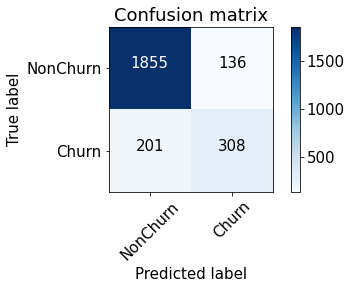

In [36]:
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [37]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

172

Пробовала по-разному параметры подбирать. Либо хуже статистика, либо не изменяется. Мб если обработать признаки будет лучше картина.

Попробуем на xgb подобрать парметры.

In [82]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

In [88]:
params = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__colsample_bytree': [0.7, 0.8],
    'classifier__max_depth': [3,5,7],
    'classifier__reg_alpha': [1.1, 1.2, 1.3],
    'classifier__reg_lambda': [1.1, 1.2, 1.3],
    'classifier__subsample': [0.7, 0.8, 0.9]
}

In [89]:
%%time
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Wall time: 58min 25s


{'classifier__colsample_bytree': 0.7,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__reg_alpha': 1.2,
 'classifier__reg_lambda': 1.1,
 'classifier__subsample': 0.8}

In [92]:
results = pd.DataFrame([
    training(classifier=Pipeline([('features', feats), ('classifier', LogisticRegression(random_state=42))])),
    training(classifier=Pipeline([('features', feats), ('classifier', GradientBoostingClassifier(random_state=42))])),
    training(classifier=Pipeline([('features', feats), ('classifier', RandomForestClassifier(random_state=42))])),
    training(classifier=Pipeline([('features', feats), ('classifier', xgb.XGBClassifier(random_state=42, 
                                                                                        use_label_encoder=False, 
                                                                                        eval_metric='logloss'))])),
    training(classifier=Pipeline([('features', feats), ('classifier', xgb.XGBClassifier(random_state=42, 
                                                                                        use_label_encoder=False, 
                                                                                        eval_metric='logloss',
                                                                                        colsample_bytree=0.7,
                                                                                        max_depth=3,
                                                                                        n_estimators=100,
                                                                                        reg_alpha=1.2,
                                                                                        reg_lambda=1.1,
                                                                                        subsample=0.8))]))
], columns=['Best Threshold', 'F', 'Precision', 'Recall', 'ROC AUC', 'TP', 'FP', 'TN', 'FN'])

results['models'] = ['LogisticRegression', 'GradientBoostingClassifier', 'RandomForestClassifier', 
                     'XGBClassifier', 'XGBClassifier_2']
results = results.set_index('models')

In [93]:
results

,Best Threshold,F,Precision,Recall,ROC AUC,TP,FP,TN,FN
models,,,,,,,,,
LogisticRegression,0.290,0.510,0.462,0.568,0.772,288,336,1655,221
GradientBoostingClassifier,0.409,0.646,0.704,0.597,0.876,303,128,1863,206
RandomForestClassifier,0.380,0.641,0.654,0.629,0.864,314,158,1833,195
XGBClassifier,0.373,0.626,0.619,0.633,0.861,321,198,1793,188
XGBClassifier_2,0.344,0.636,0.614,0.660,0.871,335,211,1780,174


In [94]:
retain_sum = (198 + 321) * 1
income = 321 * 2

income - retain_sum

123

In [95]:
retain_sum = (211 + 335) * 1
income = 335 * 2

income - retain_sum

124

С градиентным бустингом кончено не сравнится, но немного получше статистика стала после подбора парметров. 